In [1]:
from functools import partial
import jax
from jax import grad, jit, lax, random, vmap
import jax.numpy as jnp
import jax.scipy as scipy
import matplotlib.pyplot as plt

In [2]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [3]:
plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["font.size"] = 24

# Bayesian Methods

In [4]:
SEED = 11 * 2 * 2021
key = random.PRNGKey(SEED)
key, subkey = random.split(key)

## Joint probability distributions

The main idea behind these Bayesian methods is that we consider a distribution of possible parameters $\theta$ alongside our data $y$. This means that when building a model, we are attempting to discribe a joint probability distribution between our data and our parameters:

$$
(y, \theta) \mapsto p(y, \theta).
$$

In this way, fixing parameters $\theta_{0}$ and simulating data means conditioning this joint distribution on fixed $\theta_{0}$, so that we have $p(y \mid \theta = \theta_{0})$. Having data means that we're instead conditioning on fixed $y_{\text{obs}}$, so that we have $p(\theta \mid y = y_{\text{obs}})$. In short, actually finding this distribution means we gave a distribution of parameters which are consistent with the data we've observed. This is called the **posterior distribution**. 

## Encoding prior information

In order to get these estimates, we need to first specify a probability model on our parameters $\theta$. This is more of an art than a science. Typically, you can use diffusive priors (with a high variance) when you're largely uncertain of parameter values and tighter priors when you have more confidence. Additionally, we can use prior distributions that constrain the possible values of our parameters to intervals of interest. For example, this might include restricting the probability of winning a coin flip to $[0,1]$.

In general, we will want to simulate from the prior distirbution to see if we can replicate behavior similar to our model and to see if we're reasonably distributing our prior probability mass.

## Getting a posterior distribution

Given that we've observed our data, what is the most likely distribution of underlying parameters. In short, we get a posterior distribution by conditioning on our observed data, so that

\begin{align}
p(\theta \mid y) &= \frac{p(y, \theta)}{p(y)}\\
                 &= \frac{p(y\mid \theta) p(\theta)}{p(y)}\\
                 &= \frac{ L(\theta \mid y) p(\theta)}{\int_{\Theta} p(y\mid \theta) d\theta}
\end{align}

In the above, we've been able to split our posterior distribution into a term that is the likelihood from the previous notebook, the prior, and a scaling factor which does not depend on $\theta$ (it's an integral over all possible $\theta$).

## Obtaining the posterior

There are various methods for obtaining the posterior. Sometimes, we can take advantages of conjugacies between certain distributions to get the posterior in analytic or somewhat simplified form. We can also use methods for drawing samples from our posterior distribution called Markov Chain Monte Carlo (MCMC). There are also other methods from drawing from complicated distributions, but the gold standard is really MCMC. Other (collections of) methods such as variational Bayes are becoming popular nowadays as folks try to scale this framework to bigger data sets.

In general, Bayesian methods are very good for complicated models where uncertainty quantification is desired or one would like incorporate uncertainty in parameter values into the model fitting process.

## Example: Linear regression returns

Let's cast the same linear regression problem into a Bayesian context.


\begin{align}
\beta \sim_{\text{i.i.d}} \text{Normal}(0, 100)\\
\sigma \sim \text{HalfNormal}(0, 20)\\
y \sim \text{Normal}(X \beta, \sigma)
\end{align}


In [5]:
## Linear models
def linear_expectation(X, β):
    return jnp.dot(X, β)

def simulate_linear_data(X, β, σ, key = None):
    if key is None:
        key = random.PRNGKey(SEED)
        
    key, subkey = random.split(key)
    EY = jnp.dot(X, β)
    return EY + σ*random.normal(subkey, EY.shape)

X = jnp.stack([jnp.repeat(1, 100), 
               jnp.array([t for t in range(100)])]).T # Feature matrix
β = jnp.array([2.0, 0.1]) # True parameters
σ = 1.0 # Noise level

Y = simulate_linear_data(X, β, σ, key = key) # Simulated data

Text(0, 0.5, 'Brownies consumed')

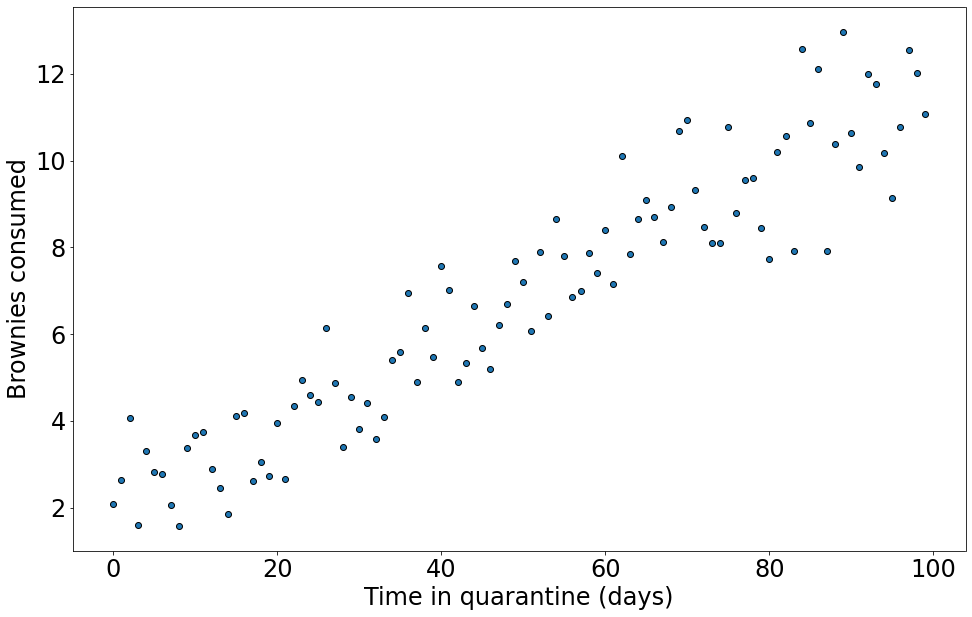

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:,1], Y, 
           edgecolors='k') # Plotting X in time 
ax.set_xlabel("Time in quarantine (days)")
ax.set_ylabel("Brownies consumed")

In [7]:
def lr(X, Y = None):
    β_shape = X.shape[1]
    
    with numpyro.plate("i", β_shape):
        beta = numpyro.sample("beta", dist.Normal(0, 100))
    
    sigma = numpyro.sample("sigma", dist.TruncatedNormal(
        low=0.0,
        loc=0.0,
        scale= 100.0,
        ))
    
    EY = numpyro.deterministic("EY", jnp.dot(X, beta))
    numpyro.sample("Y", dist.Normal(EY, sigma), obs=Y)
    return None

In [8]:
# use dense_mass for better mixing rate
MCMC_PARMS = {"num_warmup": 500, "num_samples": 500, "num_chains": 1}

mcmc = MCMC(NUTS(lr, dense_mass=True),
            num_warmup=MCMC_PARMS["num_warmup"],
            num_samples=MCMC_PARMS["num_samples"],
            num_chains=MCMC_PARMS["num_chains"])

key, subkey = random.split(key)
mcmc.run(key, X=X, Y=Y)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 376.62it/s, 11 steps of size 3.98e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      1.93      0.19      1.93      1.62      2.24    265.93      1.00
   beta[1]      0.10      0.00      0.10      0.09      0.10    301.51      1.00
     sigma      1.05      0.07      1.05      0.93      1.16    186.88      1.00

Number of divergences: 0


In [9]:
samples = mcmc.get_samples() # Retrieve posterior samples

In [10]:
samples

{'EY': DeviceArray([[ 2.1167448,  2.21202  ,  2.3072953, ..., 11.358446 ,
               11.453721 , 11.548996 ],
              [ 1.6728735,  1.7755094,  1.8781453, ..., 11.628555 ,
               11.731192 , 11.833827 ],
              [ 1.6793566,  1.7813938,  1.883431 , ..., 11.576965 ,
               11.679003 , 11.78104  ],
              ...,
              [ 1.5767957,  1.6766373,  1.7764788, ..., 11.261428 ,
               11.361269 , 11.461111 ],
              [ 1.8522273,  1.9550515,  2.0578759, ..., 11.826178 ,
               11.929002 , 12.031826 ],
              [ 1.6925726,  1.7977483,  1.9029241, ..., 11.894618 ,
               11.999794 , 12.104969 ]], dtype=float32),
 'beta': DeviceArray([[2.1167448 , 0.09527527],
              [1.6728735 , 0.1026359 ],
              [1.6793566 , 0.10203721],
              [1.9710387 , 0.09770513],
              [1.4441187 , 0.10732897],
              [1.7679988 , 0.10044172],
              [1.6340344 , 0.10084299],
              [1.52711

(array([  5.,  15.,  41.,  92., 127., 114.,  75.,  22.,   6.,   3.]),
 array([1.3251647, 1.4528956, 1.5806265, 1.7083575, 1.8360884, 1.9638193,
        2.0915504, 2.2192812, 2.347012 , 2.4747431, 2.602474 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

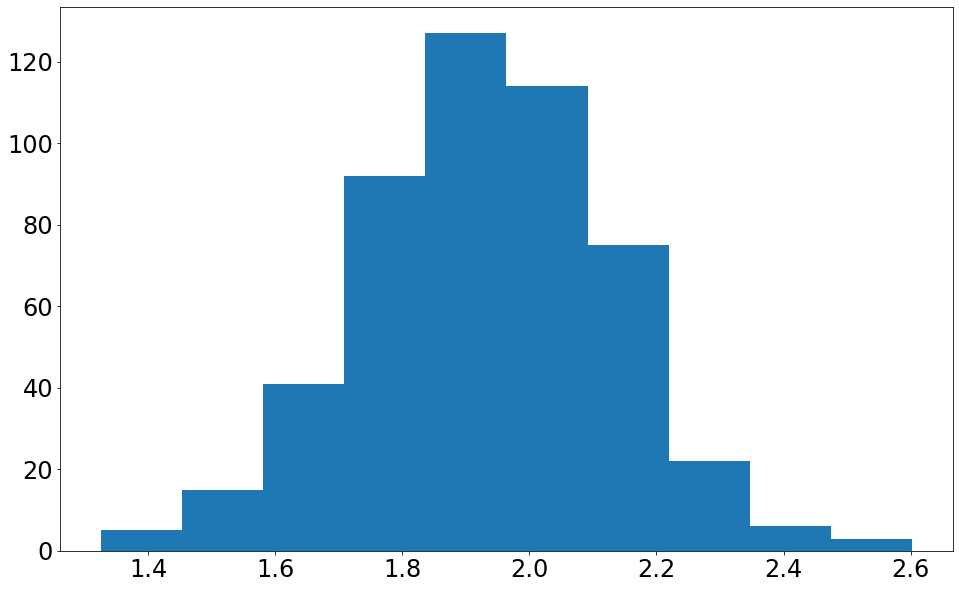

In [11]:
plt.hist(samples["beta"][:,0])

(array([  6.,  12.,  51.,  84., 104., 133.,  70.,  31.,   7.,   2.]),
 array([0.08789229, 0.09004999, 0.09220769, 0.0943654 , 0.0965231 ,
        0.0986808 , 0.1008385 , 0.10299621, 0.10515391, 0.10731161,
        0.10946932], dtype=float32),
 <BarContainer object of 10 artists>)

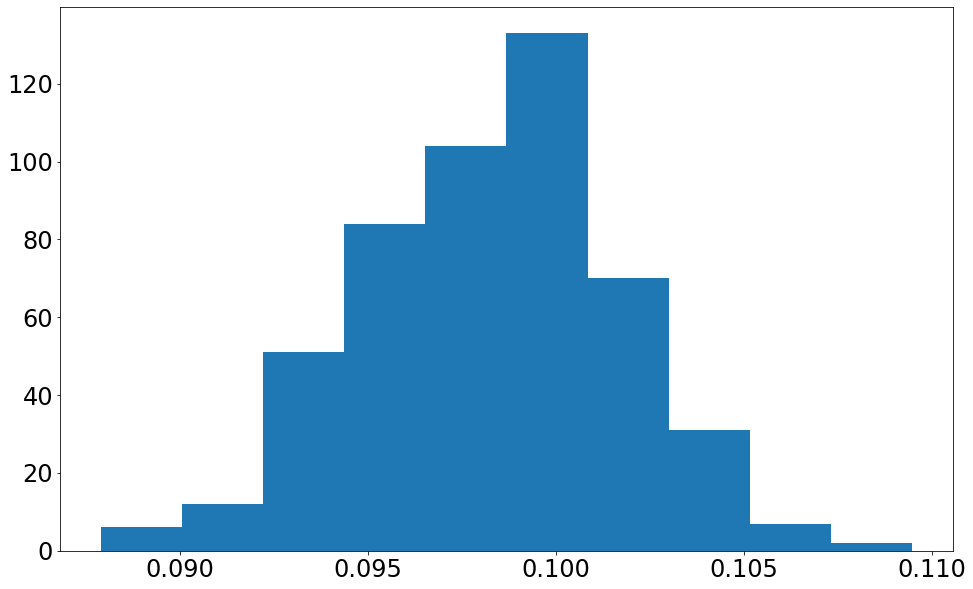

In [12]:
plt.hist(samples["beta"][:,1])

Text(0, 0.5, 'Brownies consumed')

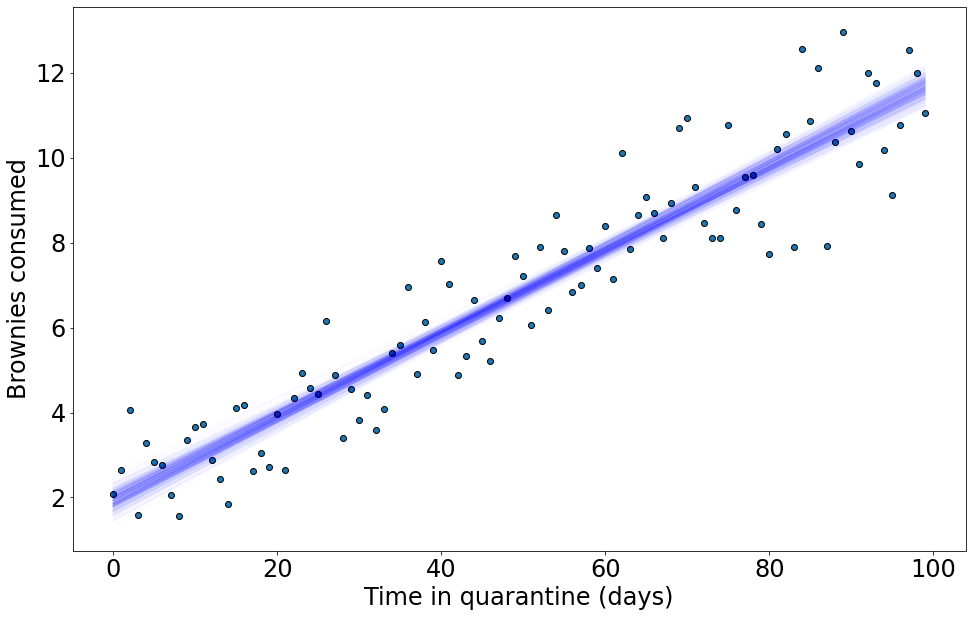

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:,1], Y, 
           edgecolors='k') # Plotting X in time 

ax.plot(X[:,1], samples["EY"].T, color = "b", alpha = 0.01)
ax.set_xlabel("Time in quarantine (days)")
ax.set_ylabel("Brownies consumed")

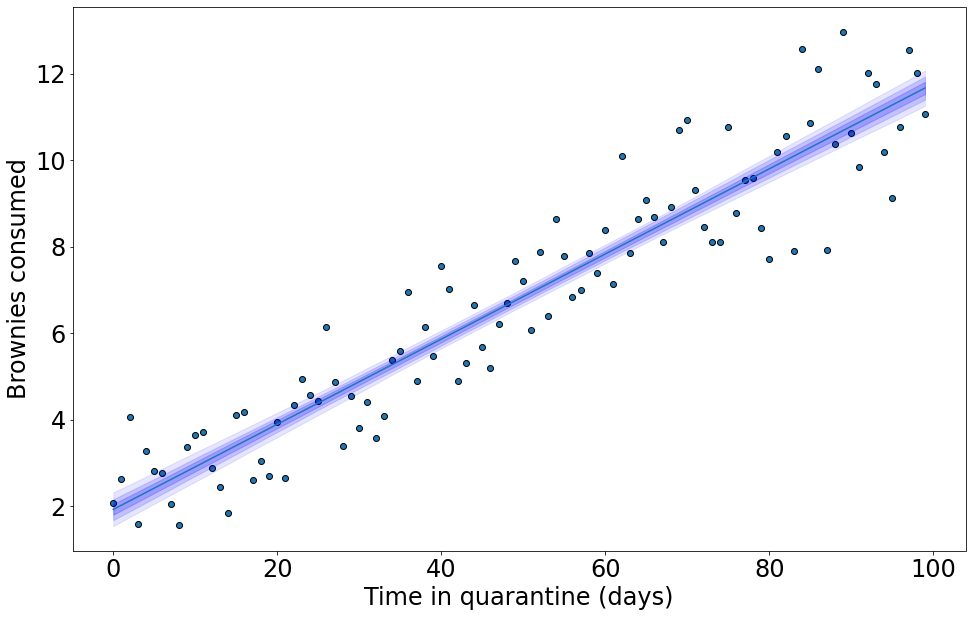

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:,1], Y, 
           edgecolors='k') # Plotting X in time 

# Plot 95%
mu, pi = jnp.mean(samples["EY"], 0), jnp.percentile(samples["EY"], jnp.array([2.5, 97.5]), 0)
ax.fill_between(X[:,1], pi[0,:],  pi[1,:], color="b",  alpha=0.1)

# Plot 80%
mu, pi = jnp.mean(samples["EY"], 0), jnp.percentile(samples["EY"], jnp.array([10, 90]), 0)
ax.fill_between(X[:,1], pi[0,:],  pi[1,:], color="b",  alpha=0.15)

# Plot 50%
mu, pi = jnp.mean(samples["EY"], 0), jnp.percentile(samples["EY"], jnp.array([25, 75]), 0)
ax.fill_between(X[:,1], pi[0,:],  pi[1,:], color="b",  alpha=0.2)
ax.plot(X[:,1], mu)

ax.set_xlabel("Time in quarantine (days)")
ax.set_ylabel("Brownies consumed")

fig;

## Example: Fitting the Lotka-Volterra model 

We'll now fit a Bayesian version of our Lotka-Volterra model. The idea and model here are borrowed from
[Example: Predator-Prey Model — NumPyro  documentation](https://num.pyro.ai/en/stable/examples/ode.html) and [Predator-Prey Population Dynamics:  the Lotka-Volterra model in Stan](https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html) with slight changes.

In [15]:
from jax.experimental.ode import odeint

@jit
def LV_step(u, t, θ):
    x, y =  (u[0], u[1])
    α, β, γ, δ = (θ[0], θ[1], θ[2], θ[3])
    
    dx_dt = (α - β*y)*x
    dy_dt = (-γ + δ*x)*y
    return jnp.stack([dx_dt, dy_dt])

true_θ = (0.55, 0.028, 0.8, 0.024)    
σ = 0.1 
u0 = jnp.array([30., 4.])
t = jnp.arange(20.)
Y = odeint(LV_step, u0, t, true_θ)

In [16]:


# Borrowed from: https://num.pyro.ai/en/stable/examples/ode.html
def model(N, y=None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    
    # measurement times
    ts = jnp.arange(float(N))
    # parameters alpha, beta, gamma, delta of dz_dt
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 0.05, 1.0, 0.05]),
            scale=jnp.array([0.5, 0.05, 0.5, 0.05]),
        ),
    )
    
    # Integrate Lotka-Volterra equations
    z = odeint(LV_step, z_init, ts, theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    
    # measurement errors
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([2]))
    # measured populations
    numpyro.sample("y", dist.LogNormal(jnp.log(z), sigma), obs=y)
    return None
   
# Simualate synthetic data
data = dist.LogNormal(jnp.log(Y), σ).sample(key)

In [17]:
# use dense_mass for better mixing rate
MCMC_PARMS = {"num_warmup": 500, "num_samples": 500, "num_chains": 1}

mcmc = MCMC(NUTS(model, dense_mass=True),
            num_warmup=MCMC_PARMS["num_warmup"],
            num_samples=MCMC_PARMS["num_samples"],
            num_chains=MCMC_PARMS["num_chains"])

key, subkey = random.split(key)
mcmc.run(key, N=data.shape[0], y=data)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:06<00:00, 146.09it/s, 7 steps of size 5.31e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.09      0.02      0.09      0.07      0.12    549.62      1.00
  sigma[1]      0.11      0.02      0.10      0.08      0.14    467.76      1.00
  theta[0]      0.56      0.02      0.56      0.53      0.59    597.95      1.00
  theta[1]      0.03      0.00      0.03      0.03      0.03    787.83      1.00
  theta[2]      0.79      0.03      0.79      0.75      0.84    663.70      1.00
  theta[3]      0.02      0.00      0.02      0.02      0.03    693.49      1.00
 z_init[0]     29.66      0.98     29.65     28.12     31.19    531.49      1.00
 z_init[1]      4.06      0.19      4.04      3.76      4.34    503.36      1.00

Number of divergences: 0


## Posterior predictive populations

In [18]:
# predict populations
pop_pred = Predictive(model, mcmc.get_samples())(subkey, data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), jnp.percentile(pop_pred, jnp.array([10, 90]), 0)
year = 1900 + t

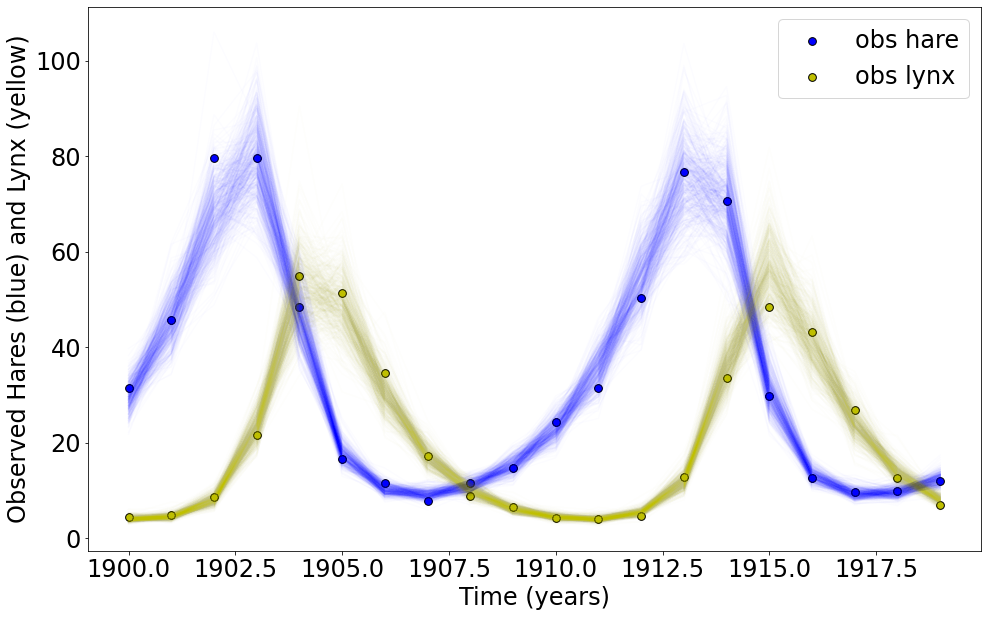

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(year, data[:, 0], color = "b", label="obs hare", s = 60, edgecolors='k')
ax.plot(year, pop_pred[:,:,0].T, color="b", alpha=0.01)

ax.scatter(year, data[:, 1], color = "y", label="obs lynx", s = 60, edgecolors='k')
ax.plot(year, pop_pred[:,:,1].T, color="y", alpha=0.01)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Hares (blue) and Lynx (yellow)")
ax.legend()


## Investigating the posterior

In [20]:
samples = mcmc.get_samples() # Retrieve posterior samples

In [21]:
def run_LV(theta, z_init, ts):
    return odeint(LV_step, z_init, ts, theta, rtol=1e-6, atol=1e-5)

run_LV_batched = vmap(run_LV, in_axes = (0, 0, None)) # Batching integration over posterior samples
ts = jnp.arange(0, 30, 0.05) # Time span to integrate over
posterior_dynamics = run_LV_batched(samples["theta"], samples["z_init"], ts) # Get posterior dynamics

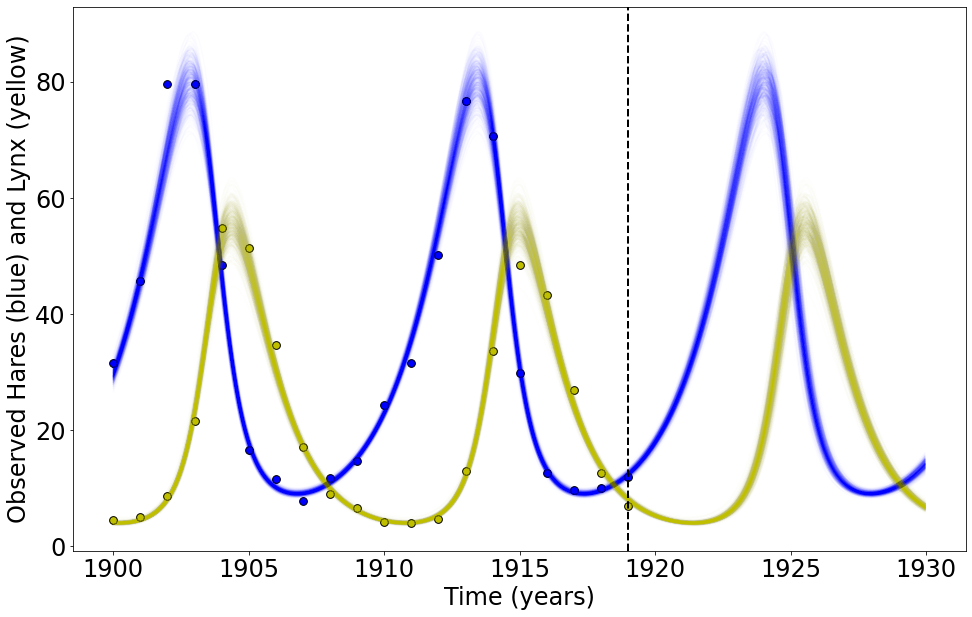

In [22]:
# Plot posterior dynamics
fig = plt.figure()
ax = fig.add_subplot(111)

plt_ts = 1900 + ts
ax.plot(plt_ts, posterior_dynamics[:,:,0].T, color="b", alpha=0.01, label="hare population")
ax.plot(plt_ts, posterior_dynamics[:,:,1].T, color="y", alpha=0.01, label="lynx population")

ax.scatter(year, data[:, 0], color = "b", label="obs hare", s = 60, edgecolors='k')
ax.scatter(year, data[:, 1], color = "y", label="obs lynx", s = 60, edgecolors='k')

ax.axvline(year[-1], linewidth=2, color='k', linestyle = "--")

ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Hares (blue) and Lynx (yellow)")
fig;

In [23]:
# Get uncertainty intervals from samples
mu, pi = jnp.mean(posterior_dynamics, 0), jnp.percentile(posterior_dynamics, jnp.array([10, 90]), 0)

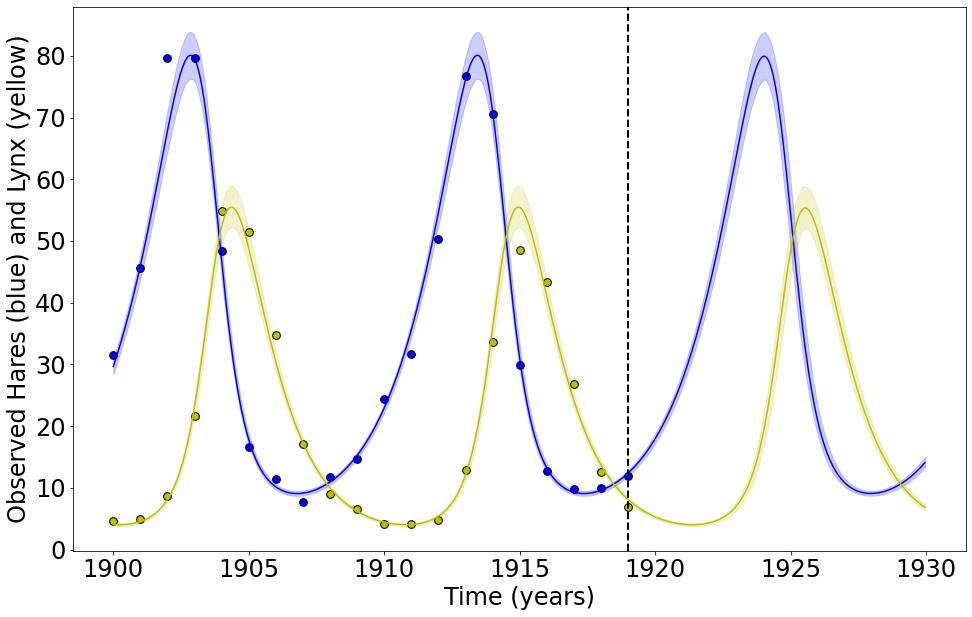

In [24]:
# Plot posterior dynamics with uncertainty
fig = plt.figure()
ax = fig.add_subplot(111)

plt_ts = 1900 + ts
ax.plot(plt_ts, mu[:,0], color="b", label="hare population")
ax.fill_between(plt_ts, pi[0,:,0],  pi[1,:,0], color="b", alpha=0.2)

ax.plot(plt_ts, mu[:,1], color="y", label="lynx population")
ax.fill_between(plt_ts, pi[0,:,1],  pi[1,:,1], color="y",  alpha=0.2)

ax.scatter(year, data[:, 0], color = "b", label="obs hare", s = 60,edgecolors='k')
ax.scatter(year, data[:, 1], color = "y", label="obs lynx", s = 60, edgecolors='k')

ax.axvline(year[-1], linewidth=2, color='k', linestyle = "--")

ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Hares (blue) and Lynx (yellow)")
fig;

## References and further reading

This is a huge field, but here's some references to get you started.

## Books

Statistical Rethinking: A Bayesian Course with Examples in R and Stan by Richard McElreath
    - Pretty good first pass.
    
Bayesian Data Analysis by Andrew Gelman, John Carlin, Aki Vehtari, Hal S. Stern, David Dunson, Donald Rubin
    - Very terse but very good.
    - [Freely available for non-commerical purposes](https://users.aalto.fi/~ave/BDA3.pdf)

Introducing Monte Carlo Methods with R by Christian P. Robert and George Casella
    - Introduction to Monte Carlo methods in general introduces Metropolis-Hasting and Gibbs 
    
## Blog posts

[Example: Predator-Prey Model — NumPyro  documentation](https://num.pyro.ai/en/stable/examples/ode.html)

[Predator-Prey Population Dynamics:  the Lotka-Volterra model in Stan](https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html)

[Towards a principled Bayesian workflow](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html)

[Hierarchical modeling](https://betanalpha.github.io/assets/case_studies/hierarchical_modeling.html)

[Modeling sparsity](https://betanalpha.github.io/assets/case_studies/modeling_sparsity.html)

## Software

[Stan](https://mc-stan.org/users/documentation/)
- Low level probablistic programming language built off of C++.
- Great documentation
- Has interfaces for basically every single programming language
- Can be difficult to incorporate in larger workflows in a single language
- NUTS is main algorithm for inference
- Optimized stan code is disturbingly fast

[NumPyro](https://num.pyro.ai/)
- Probabilistic programming library in Python
- Built on JAX for autodifferentiation
- Can be used on GPU / CPU
- Multiple inference algorithms available
- Developing variational inference scene
- Can be a bit slower

[PyMC3](https://docs.pymc.io/en/stable/about.html)
- PPL in Python
- Built on Theano
- Multiple inference algorithms available
- Haven't used much personally